In [1]:
# Make a pretty picture!
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.io import fits
from astropy.convolution import convolve_fft

from astroduet.config import Telescope
from astroduet.lightcurve import get_lightcurve
from astroduet.background import background_pixel_rate
from astroduet.utils import duet_abmag_to_fluence, duet_fluence_to_abmag

duet = Telescope() # Do we need to declare a certain telescope mode?
datadir = os.path.join(os.getcwd(), '../astroduet/data')

exposure = 300 * u.s

# About GALEX
galex_pixel_size = 1.5 * u.arcsec
galex_fwhm = 5.3 * u.arcsec

# About DUET
duet_pixel_size = duet.pixel
sky_rate1, sky_rate2 = background_pixel_rate(duet, low_zodi = True)

In [2]:
# Load the GALEX image
#gal_name = 'M83'
#galex_file = fits.open(datadir+'/M83_GALEX_NUV.fits')
#dist_mod = 5 * np.log10(4.66e5)
gal_name = 'UGC 8475'
galex_file = fits.open(datadir+'/UGC_8475_GALEX_NUV.fits')
dist_mod = 5 * np.log10(91.1333e5)
galex_image = galex_file[0].data
galex_file.close()

# Generate GALEX image and axes (match to the slicing below)
# We only really need this if we want WCS axes
#import aplpy
#c_ra, c_dec = ..., ...    # Image centre (...,...) in World coordinates
#w, h = 0.4, 0.4                            # in degrees
#fig = aplpy.FITSFigure(datadir+'/[filename].fits',figsize=(8,6))
#fig.recenter(c_ra, c_dec, width=w, height=h)
#fig.show_colorscale(cmap='viridis')

size = 800 # size in galex pixels: 800x800 GALEX pixels = 20 x 20 arcmin
cx, cy = 1540, 2025

# Grab a square slice from within the image, 
galex_image = galex_image[cy-size//2:cy+size//2,cx-size//2:cx+size//2]

# Convert GALEX count rates to AB magnitude per pixel
# From https://asd.gsfc.nasa.gov/archive/galex/FAQ/counts_background.html
#FUV: mAB = -2.5 x log10(CPS) + 18.82
nuv_zp = 20.08 
nuv_ab = (-2.5 * np.log10(galex_image) + nuv_zp) * u.ABmag
fluence1 = duet_abmag_to_fluence(nuv_ab, 1, duet=duet)
duet_countrate1 = duet.fluence_to_rate(fluence1)

/Users/bwgref/science/local/anaconda/envs/duet/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


In [3]:
# Make a 'supernova' to add to the image
sn_abmag = (dist_mod - 18.5) * u.ABmag
sn_fluence = duet_abmag_to_fluence(sn_abmag, 1, duet=duet)
source_rate = duet.fluence_to_rate(sn_fluence)

# Create supernova cutout
oversample = 6
pixel_size_init = duet.pixel / oversample
psf_kernel = duet.psf_model(pixel_size = pixel_size_init)
sn_array = np.zeros((60,60)) * u.ph / u.s
sn_array[31, 31] += source_rate
sn_psf = convolve_fft(sn_array.value, psf_kernel) * u.ph / u.s
shape = (sn_array.shape[0] // oversample, oversample, sn_array.shape[1] // oversample, oversample)
sn_binned = sn_psf.reshape(shape).sum(-1).sum(1)

# Convolve original galaxy image with the DUET kernel 
#(this ends up making the resulting PSF a little bigger, but not by more than an arcsec)
psf_kernel = duet.psf_model(pixel_size = galex_pixel_size)
psf_image = convolve_fft(duet_countrate1, psf_kernel) * duet_countrate1.unit

# Bin up by four to approximate DUET pixel size (to-do later - maybe some more sophisticated up- and down-sampling)
shape = (galex_image.shape[0] // 4, 4, galex_image.shape[1] // 4, 4)
binned_image1 = psf_image.reshape(shape).sum(-1).sum(1)

# Add sky rate, dark current
binned_image1 += sky_rate1
binned_image1 += duet.dark_current

# Going forward, we have original galaxy image and galaxy+sn
snx, sny = 95,83
binned_image2 = binned_image1.copy()
binned_image2[sny-5:sny+5,snx-5:snx+5] += sn_binned

# Convert to counts
counts1 = binned_image1 * exposure
counts2 = binned_image2 * exposure

# Add noise
noise1 = np.random.poisson(counts1.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts1.shape)
duet_image1 = np.floor(noise1)
duet_image1[(duet_image1 <= 0) | (np.isnan(duet_image1))] = 0.01
duet_image1[duet_image1 > 20000] = 20000

# Add associated noise for the second observation
noise2 = np.random.poisson(counts2.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts2.shape)
duet_image2 = np.floor(noise2)
duet_image2[(duet_image2 <= 0) | (np.isnan(duet_image2))] = 0.01
duet_image2[duet_image2 > 20000] = 20000

2559.0


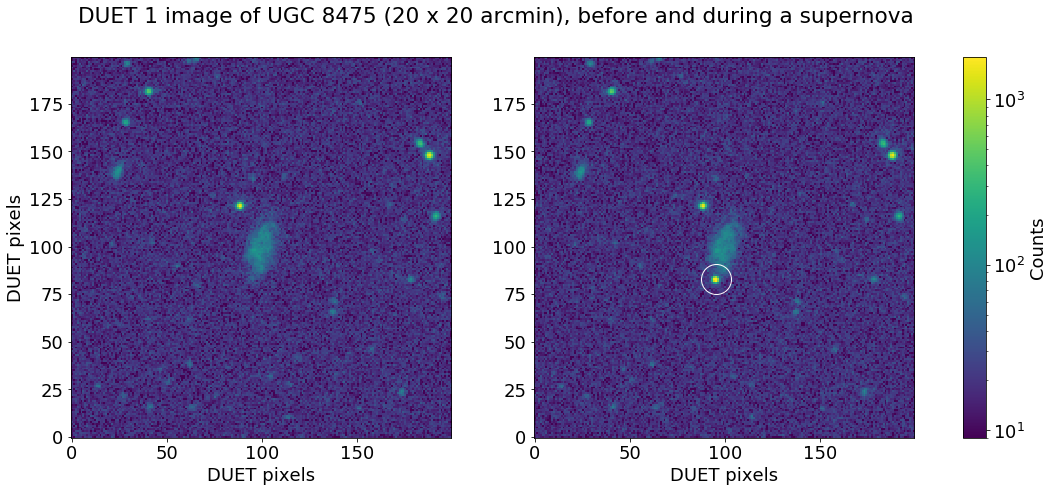

In [4]:
import matplotlib
font = {'family' : 'sans',
        'size'   : 18}
matplotlib.rc('font', **font)

fig, (ax, ax2, cax) = plt.subplots(ncols=3,figsize=(17,7), 
                  gridspec_kw={"width_ratios":[1,1,0.05]})
fig.subplots_adjust(wspace=0.05)

fig.suptitle('DUET 1 image of '+gal_name+' (20 x 20 arcmin), before and during a supernova')

print(np.max(duet_image2))

im = ax.imshow(duet_image1, cmap='viridis', aspect=1, origin='lower', norm=LogNorm(vmin=9, vmax=1800))
ax.set_xlabel('DUET pixels')
ax.set_ylabel('DUET pixels')

im2 = ax2.imshow(duet_image2, cmap='viridis', aspect=1, origin='lower', norm=LogNorm(vmin=9, vmax=1800))
ax2.plot([snx],[sny],marker='o',ms=30,mfc='None',mec='white')
ax2.set_xlabel('DUET pixels')

fig.colorbar(im, cax=cax,label='Counts')
plt.show()

In [14]:
f = open('reference_ugc8475.txt', 'w')
f2 = open('reference_ugc8475_wSne.txt', 'w')

nx, ny = duet_image1.shape

for x in np.arange(nx):
    for y in np.arange(ny):
        f.write('{} '.format(duet_image1[x][y]))
        f2.write('{} '.format(duet_image2[x][y]))
        
    f.write('\n')
    f2.write('\n')
f.close()
f2.close()